In [117]:
import open3d as o3d
import numpy as np
from open3d import JVisualizer
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import copy 

In [118]:
def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))
    # orient normals so the ground is facing the same way
    pcd_down.orient_normals_to_align_with_direction()
    pcd_down = remove_ground_points(pcd_down)

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

In [119]:
def prepare_dataset(voxel_size):
    print(":: Load two point clouds and disturb initial pose.")
    source = o3d.io.read_point_cloud("/home/zak/senior_design/ros_livox/maps/fri_mar_12/surf.pcd")
    target = o3d.io.read_point_cloud("/home/zak/senior_design/ros_livox/maps/mon_mar_15_after_snow_2/surf.pcd")
    trans_init = np.asarray([[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
    #source.transform(trans_init)
    draw_registration_result(source, target, np.identity(4))

    source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
    target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)
    return source, target, source_down, target_down, source_fpfh, target_fpfh

In [120]:
def remove_ground_points(pcd):
    pop_list = []
    for i, normal in enumerate(pcd.normals):
        if normal[2] > 0.4:
            pop_list.append(i)
    
    print("Number of points to be removed: ", len(pop_list))
    pop_list.sort(reverse=True)
    for item in pop_list:
        pcd.normals.pop(item)
        pcd.points.pop(item)
    
    return pcd

In [121]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4559,
                                      front=[0.6452, -0.3036, -0.7011],
                                      lookat=[1.9892, 2.0208, 1.8945],
                                      up=[-0.2779, -0.9482, 0.1556])

In [122]:
voxel_size = 0.4 # means 5cm for this dataset
source, target, source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(
    voxel_size)

:: Load two point clouds and disturb initial pose.
:: Downsample with a voxel size 0.400.
:: Estimate normal with search radius 0.800.
Number of points to be removed:  39036
:: Compute FPFH feature with search radius 2.000.
:: Downsample with a voxel size 0.400.
:: Estimate normal with search radius 0.800.
Number of points to be removed:  42018
:: Compute FPFH feature with search radius 2.000.


In [125]:
def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    print(":: RANSAC registration on downsampled point clouds.")
    print("   Since the downsampling voxel size is %.3f," % voxel_size)
    print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
    return result

In [124]:
result_ransac = execute_global_registration(source_down, target_down,
                                            source_fpfh, target_fpfh,
                                            voxel_size)
print(result_ransac)
draw_registration_result(source_down, target_down, result_ransac.transformation)

:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.400,
   we use a liberal distance threshold 0.600.
RegistrationResult with fitness=1.015072e-02, inlier_rmse=3.759122e-01, and correspondence_set size of 33
Access transformation to get result.


In [126]:
print(result_ransac.transformation)

[[ 0.84650019 -0.48854934  0.21155843  0.58806219]
 [ 0.48034673  0.87221799  0.09221057 -0.26443517]
 [-0.22957449  0.02356513  0.97300578  1.76829601]
 [ 0.          0.          0.          1.        ]]


In [127]:
def refine_registration(source, target, source_fpfh, target_fpfh, voxel_size):
    distance_threshold = voxel_size * 0.4
    print(":: Point-to-plane ICP registration is applied on original point")
    print("   clouds to refine the alignment. This time we use a strict")
    print("   distance threshold %.3f." % distance_threshold)
    target.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    source.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    result = o3d.pipelines.registration.registration_icp(
        source_down, target_down, distance_threshold, result_ransac.transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    return result

In [128]:
result_icp = refine_registration(source, target, source_fpfh, target_fpfh,
                                 voxel_size)
print(result_icp)

:: Point-to-plane ICP registration is applied on original point
   clouds to refine the alignment. This time we use a strict
   distance threshold 0.160.
RegistrationResult with fitness=1.225390e-01, inlier_rmse=1.217136e-01, and correspondence_set size of 2639
Access transformation to get result.


In [129]:
np.set_printoptions(suppress=True)
print(result_icp.transformation)

[[ 0.84435017 -0.49212627  0.21185969  0.31288059]
 [ 0.48470511  0.87009828  0.08938642 -0.55672585]
 [-0.22832816  0.02721604  0.97320375  1.91496325]
 [ 0.          0.          0.          1.        ]]


In [130]:
draw_registration_result(source, target, result_icp.transformation)

In [136]:
before_snow = o3d.io.read_point_cloud("/home/zak/senior_design/ros_livox/maps/fri_mar_12/all_points.pcd")
after_snow = o3d.io.read_point_cloud("/home/zak/senior_design/ros_livox/maps/mon_mar_15_after_snow_2/all_points.pcd")
#after_snow.transform(result_icp.transformation)
draw_registration_result(before_snow, after_snow, result_icp.transformation)

In [138]:
dists = after_snow.compute_point_cloud_distance(before_snow)
dists = np.asarray(dists)
ind = np.where(dists > 0.5)[0]
snow_result = after_snow.select_by_index(ind)
o3d.visualization.draw_geometries([snow_result],
                                      zoom=0.4559,
                                      front=[0.6452, -0.3036, -0.7011],
                                      lookat=[1.9892, 2.0208, 1.8945],
                                      up=[-0.2779, -0.9482, 0.1556])

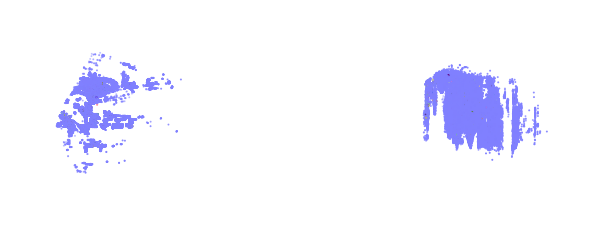

In [67]:
points = np.asarray(snow_result.points)
colors = (0.5, 0.5, 0.5) + np.asarray(snow_result.normals) * 0.5

figsize = plt.rcParams.get('figure.figsize')
fig = plt.figure(figsize=(figsize[0] * 2, figsize[1]))
ax1 = fig.add_subplot(1, 2, 1, projection = '3d')
ax2 = fig.add_subplot(1, 2, 2, projection = '3d')
ax1.axis("off")
ax1.view_init(90, -90) # front view
ax1.scatter(points[:,0], points[:,1], points[:,2], s=1, c=colors)
ax2.axis("off")
ax2.view_init(90 + 90, -90) # top view
ax2.scatter(points[:,0], points[:,1], points[:,2], s=1, c=colors)
plt.show()

In [134]:
o3d.io.write_point_cloud("snow_result.pcd", snow_result)

True

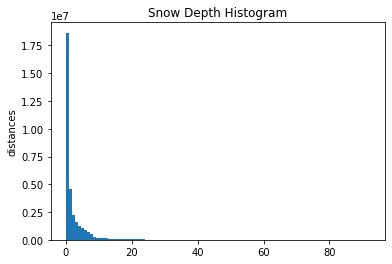

In [133]:
n_bins = 100
fig, ax = plt.subplots()

# We can set the number of bins with the `bins` kwarg
ax.hist(dists, bins=n_bins)


ax.set_ylabel('distances')
ax.set_title('Snow Depth Histogram')

plt.show()